**学習(Fine Tuning)**

In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install sentencepiece
!pip install rouge_score
!pip install scipy
!pip install evaluate
!pip install torchinfo

In [ ]:
from datetime import datetime
import json
import random

import datasets
import evaluate
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rouge_score
import torch
import torchinfo
import transformers

In [ ]:
torch.backends.cudnn.benchmark = True  # ループ内で順伝播や逆伝播が同じ計算手法ならば処理を高速化させる
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 事前学習済みT5モデルのチェックポイント名
model_checkpoint = "sonoisa/t5-base-japanese"
# 事前学習済みT5モデルのトークナイザーを取得
tokenizer = transformers.AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# trainとvalidationのcsvファイルをDataFrameとして読み込む(trainはデータ量が多いので最初の20%だけを使う)
train_df = pd.read_csv("./train.csv",
                       encoding="utf-8")
num_data = len(train_df)
train_1_df = train_df.iloc[:int(num_data*0.2), :].copy()  # 計算結果に小数点があってもintで整数にする
validation_df = pd.read_csv("./valid.csv",
                            encoding="utf-8")

In [ ]:
# DataFrameをDatasetへ変換
train_1_ds = datasets.Dataset.from_pandas(train_1_df)
validation_ds = datasets.Dataset.from_pandas(validation_df)
# DatasetをDatasetDictで纏める
dataset_1_dict = datasets.DatasetDict({"train": train_1_ds,
                                       "validation": validation_ds})

In [ ]:
# DatasetDictをトークン化するために使う関数(参考URL：https://huggingface.co/learn/nlp-course/ja/chapter7/5)
def tokenize_datasetdict(batch):
    max_text_length = 768  # 本文として用いる最長のトークン数
    max_summary_length = 128  # 要約として用いる最長のトークン数
    model_inputs = tokenizer(text=batch["text"],  # encoder側(今回は本文)のテキストは引数text
                             max_length=max_text_length,
                             truncation=True)
    model_target = tokenizer(text_target=batch["summary"],  # decoder側(今回は要約)のテキストは引数text_target
                             max_length=max_summary_length,
                             truncation=True)
    model_inputs["labels"] = model_target["input_ids"]  # labelsをキーとしてdecoder側のトークンIDを入れないと、後続のcollaterでdecoder_input_idsが作成されず、trainer.trainでエラーになる
    return model_inputs

In [ ]:
# DatasetDictをトークン化する
dataset_1_dict_token = dataset_1_dict.map(tokenize_datasetdict,
                                          batched=True,
                                          batch_size=None)

In [ ]:
dataset_1_dict_token

DatasetDict({
    train: Dataset({
        features: ['summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 16078
    })
    validation: Dataset({
        features: ['summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7093
    })
})

In [ ]:
# 中身を確認
sample_data_1 = dataset_1_dict_token["train"][0:3]
pd.DataFrame(data={"text": sample_data_1["text"],
                   "summary": sample_data_1["summary"]})

In [ ]:
# 中身を確認
sample_data_2 = dataset_1_dict_token["train"][0]
pd.DataFrame(data={"input_id": sample_data_2["input_ids"],
                   "attention_mask": sample_data_2["attention_mask"],
                   "token": tokenizer.convert_ids_to_tokens(sample_data_2["input_ids"])})

In [ ]:
# 中身を確認
pd.DataFrame(data={"summary_input_id": sample_data_2["labels"],
                   "summary_token": tokenizer.convert_ids_to_tokens(sample_data_2["labels"])})

In [ ]:
# 事前学習済みT5モデルのニューラルネットワークモデルを取得
nn_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(device)  # GPUへ

In [ ]:
# 学習のクラスでインスタンスを作成する時に使う関数(評価関数の算出用)
rouge_score = evaluate.load("rouge")

def compute_metric(pred):
    predict_text_ids, answer_text_ids = pred
    predict_text = tokenizer.batch_decode(predict_text_ids,
                                          skip_special_tokens=True)
    answer_text_ids = np.where(answer_text_ids != -100,
                               answer_text_ids,
                               tokenizer.pad_token_id)
    answer_text = tokenizer.batch_decode(answer_text_ids,
                                         skip_special_tokens=True)
    result_rouge = rouge_score.compute(predictions=predict_text,
                                       references=answer_text,
                                       use_stemmer=True)
    result_rouge_dict = {k: v * 100 for k, v in result_rouge.items()}
    return {k: round(v, 4) for k, v in result_rouge_dict.items()}

In [ ]:
# 学習のクラスでインスタンスを作成する時に使うインスタンス(学習で使うパラメータを持つ)
minibatch_size = 5
log_step_timing = dataset_1_dict_token["train"].num_rows // minibatch_size
training_args = transformers.Seq2SeqTrainingArguments(output_dir="./output",
                                                      evaluation_strategy="epoch",
                                                      logging_steps=log_step_timing,
                                                      log_level="error",
                                                      save_strategy="no",
                                                      save_total_limit=None,
                                                      lr_scheduler_type="linear",
                                                      learning_rate=5.6e-5,
                                                      weight_decay=0.01,
                                                      per_device_train_batch_size=minibatch_size,
                                                      per_device_eval_batch_size=minibatch_size,
                                                      num_train_epochs=1,
                                                      # fp16=True,  # 16ビット計算 # 学習は早くなるけれど、検証は遅くなるので外す
                                                      predict_with_generate=True)

In [ ]:
# 学習データのdecoder側のマスクに関する設定
training_data_collator = transformers.DataCollatorForSeq2Seq(tokenizer,
                                                             model=nn_model)
collator_test = dataset_1_dict_token.remove_columns(["summary", "text"])
collator_test_features = [collator_test["train"][i] for i in range(2)]
training_data_collator(collator_test_features)

In [ ]:
# 学習のクラスでインスタンスを作成
nn_model_trainer = transformers.Seq2SeqTrainer(model=nn_model,
                                               args=training_args,
                                               train_dataset=dataset_1_dict_token["train"],
                                               eval_dataset=dataset_1_dict_token["validation"],
                                               data_collator=training_data_collator,
                                               tokenizer=tokenizer,
                                               compute_metrics=compute_metric)

In [ ]:
# 学習
nn_model.train()
nn_model_trainer.train()

In [ ]:
# 学習(Fine Tuning)したモデルを保存
nn_model_trainer.save_model("./T5-model-after-FineTuning")
# 学習(Fine Tuning)時の損失値や評価値などの情報を保存
nn_model_trainer.save_state()

In [ ]:
# 学習(Fine Tuning)時の損失値や評価値などの情報を確認
with open("./trainer_state_1epoch_1.json", "r") as f:
    json_file_data = json.load(f)
    print(json_file_data)

# ROUGE(ルージュ)について(参考URL：https://qiita.com/icoxfog417/items/65faecbbe27d3c53d212)
# ROUGEは、正解要約テキストのN-gramのうち，どの程度が生成要約テキストに含まれているかで評価するもの。
# ROUGE-1は1gram(単語毎)での一致，ROUGE-2では2gram(連続する2単語)での一致とする。
# ROUGEは生成要約テキストを長くすればするほど，正解要約テキストとマッチするN-gramが増えるため，評価値が高くなる傾向にある。

**学習(Fine Tuning)での評価関数の値を確認**

In [2]:
# 学習(Fine Tuning)毎での損失値や評価値などの情報を確認
json_file_data_list = []
for i in range(15):
    num = i + 1
    if num % 5 == 0:
        n_epoch = num // 5
        n_data = 5
    else:
        n_epoch = (num // 5) + 1
        n_data = num % 5
    with open("./trainer_state_{a}epoch_{b}.json".format(a=n_epoch, b=n_data), "r") as f:
        json_file_data = json.load(f)
        json_file_data_list.append(json_file_data)

In [3]:
colors = list(matplotlib.colors.CSS4_COLORS.values())
random.shuffle(colors)
label2color = colors[:len(json_file_data_list)]

In [4]:
valid_rouge1_score_list = []
valid_rouge2_score_list = []
valid_rougeL_score_list = []
for i in range(len(json_file_data_list)):
    valid_rouge1_score_list.append(json_file_data_list[i]["log_history"][1]["eval_rouge1"])
    valid_rouge2_score_list.append(json_file_data_list[i]["log_history"][1]["eval_rouge2"])
    valid_rougeL_score_list.append(json_file_data_list[i]["log_history"][1]["eval_rougeL"])

In [5]:
x_data_array = np.arange(1, len(json_file_data_list)+1, 1)
x_datas = []
for i in x_data_array:
    n_epoch = ((i // 5) + 1 if i % 5 !=0 else i // 5)
    num = (i % 5 if i % 5 != 0 else 5)
    x_data = "{a}epoch_{b}".format(a=n_epoch, b=num)
    x_datas.append(x_data)
y_datas_list = [valid_rouge1_score_list,
                valid_rouge2_score_list,
                valid_rougeL_score_list]
labels = ["rouge1", "rouge2", "rougeL"]

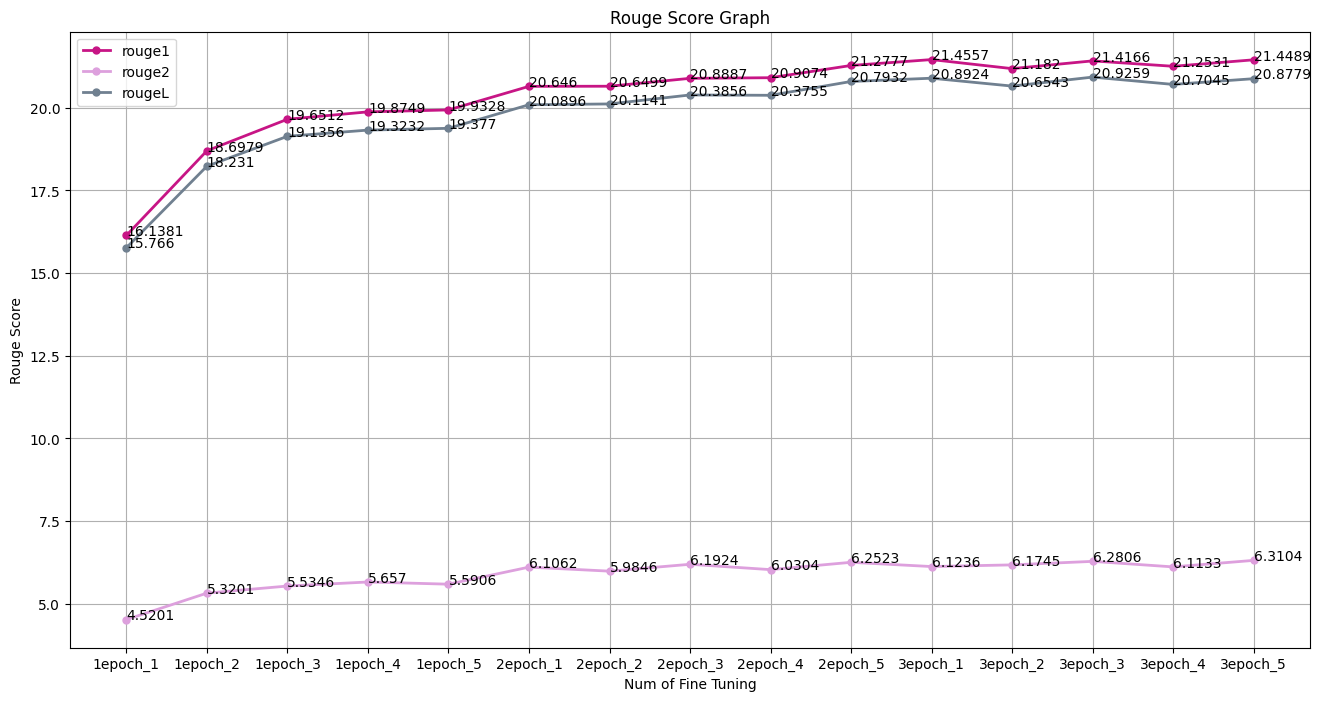

In [6]:
fig, axes = plt.subplots(nrows=1,
                         ncols=1,
                         figsize=(16, 8))
for i, y_datas in enumerate(y_datas_list):
    axes.plot(x_datas,
              y_datas,
              c=label2color[i],
              label=labels[i],
              marker="o",
              markersize=5,
              linestyle="solid",
              linewidth=2)
    for j in range(len(json_file_data_list)):
        axes.annotate(text=y_datas[j],
                      xy=(x_datas[j], y_datas[j]))
    axes.legend()
plt.title("Rouge Score Graph")
plt.xlabel("Num of Fine Tuning")
plt.ylabel("Rouge Score")
plt.xticks(ticks=x_datas)
plt.grid(True)
plt.show()

**学習(Fine Tuning)後のtestデータのテキスト要約**

In [ ]:
# Fine Tuning後のトークナイザーと、モデルを格納
tokenizer_after_ft = transformers.AutoTokenizer.from_pretrained("./T5-model-after-FineTuning")
nn_model_after_ft = transformers.AutoModelForSeq2SeqLM.from_pretrained("./T5-model-after-FineTuning").to(device)  # GPUへ

In [ ]:
torchinfo.summary(nn_model_after_ft,
                  input_size=(1, 50),  # ミニバッチ文章数は1、文章あたり50トークンをencoderに入力
                  depth=10,  # モデルでネストされている箇所をどの深さまで表示するか
                  dtypes=[torch.int],  # 自然言語処理ではdtypes(入力データの型)はintになる
                  decoder_input_ids=torch.LongTensor([(10, 20)]))  # [[10, 20]]の1行2列の行列(torch.LongTensor([10, 20])だと[10, 20]の2次元ベクトル)

Layer (type:depth-idx)                                  Output Shape              Param #
T5ForConditionalGeneration                              [1, 50, 768]              --
├─T5Stack: 1-1                                          [1, 50, 768]              109,628,544
├─T5Stack: 1-2                                          --                        (recursive)
│    └─Embedding: 2-1                                   [1, 50, 768]              24,674,304
├─T5Stack: 1-3                                          --                        (recursive)
│    └─Dropout: 2-2                                     [1, 50, 768]              --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─T5Block: 3-1                                [1, 50, 768]              --
│    │    │    └─ModuleList: 4-1                        --                        --
│    │    │    │    └─T5LayerSelfAttention: 5-1         [1, 50, 768]              --
│    │    │    │    │    

In [ ]:
# testのcsvファイルをDataFrameとして格納
test_df = pd.read_csv("./test.csv", encoding="utf-8")
test_df

,summary,text
0,ドイツ紙が、清水からデュッセルドルフに移籍した大前元紀の特集記事を掲載。「日本から来た『小さ...,ドイツ紙『Westdeutsche Allgemeine』がこの冬に清水からフォルトゥナ・デ...
1,「ゲスの極み乙女。」の全国ツアーが開催され、後半に差しかかっている。3月30、31日の日本武...,年始のとある家族が子どもの誕生日記念写真を撮影しようと、『スタジオアリス』を訪れたときのこと...
2,iPad/iPhoneで映像を見ながら物を発見できるワイヤレススコープがある。冷蔵庫と壁の隙...,スマートフォンやタブレットなどのデジタル部屋のソファや冷蔵庫の隙間など、コンタクトやアクサリ...
3,彼氏の気持ちが冷めてしまう「NGワード」を紹介。男は「彼氏なんだから」「彼氏でしょ? 」と言...,愛し合って付き合ったはずの2人。しかし、あるとき愛する男の気持ちに変化が表れてくる……。考え...
4,ドコモのカケホーダイと転送でんわ、IP電話サービスの050 plusの組み合わせを紹介。海外...,今回の渡航では日本から電話をかけてもらう時の電話番号として、050 plusの電話番号を事前...
...,...,...
7089,胸元があいたニットと超ミニスカートで好きな方を、男性に調査している。胸元があいたニットの方が...,男性は女性の露出度高めのQ.以下2つの女性ファッションから好きなのを選んでください。わずかな...
7090,結婚相手が浮気をしたときに許せるかどうか、働く女性に聞いている。お金をもらって離婚し、身辺を...,「結婚」を考えるときに、セットでどうしても考えてしまう「離婚」。そして「離婚」を考えるときに...
7091,10日の番組で、ペットを理由に会社を休むことについて有吉弘行が持論を展開。将来的に、ペットを...,「「もう、そういう世の中だしね」――有吉さんはテレビ番組でこう発言し、ペットを理由にした休暇...
7092,中山美穂と音楽家の渋谷慶一郎氏との破局を、一部週刊誌が報じた件。渋谷氏の母親は、報道には驚い...,実はこの2日前の24日、一部女性週刊誌が中山と渋谷氏の破局を報じたばかり。そんな２人がいった...


In [ ]:
# testデータのtextカラムの中身をトークン化してtokenカラムへ格納
test_df["token"] = test_df["text"].apply(lambda x: tokenizer_after_ft(text=x,
                                                                      max_length=768,
                                                                      truncation=True,
                                                                      return_tensors="pt"))

In [ ]:
tokenized_test_data_list = list(test_df["token"])

In [ ]:
tokenized_test_data_list[0]

{'input_ids': tensor([[ 7911,  1044,    35,     2,  8645,  1277,  6908,    74,  5612,     5,
             2,  5173,  2388,  1729,  3575,    32,  5310,  2049,    13,  3510,
            24,  5208,  1463,   129,     9, 30905,  8854,    19,     2,   462,
           148,  4635,     7,  9302,    21,   484,  3265, 15003,   470,   123,
             4,  4635,  5751,  9811, 25916,     4,  1868,  4264,   878, 11845,
          3639,  1382,   326, 26983,     4,  5208,  1463,   129,    24, 13596,
             8,  8440,   182,    28, 28488,     7,   991, 23661,    17,  2126,
             3,  5208,  1463,   129,     9, 30905,    14,  2379,  9493,  4069,
             9, 17414,   498,     7,    19, 10408,     7,   348,     4,  3101,
         28250, 14565,   946,     4,  1084,  1283,    86,  5757, 18191, 19763,
            17,    16,    59,  1592,  1146,   240, 15043,    53,  3461,    14,
           978,   590,     4,     5,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# 推論
with torch.no_grad():
    nn_model_after_ft.eval()
    predict_after_ft_list = []
    for tokenized_test_data in tokenized_test_data_list[:30]:  # 1～30文章目だけをテキスト要約
        output_after_ft = nn_model_after_ft.generate(input_ids=tokenized_test_data["input_ids"].to(device),
                                                    attention_mask=tokenized_test_data["attention_mask"].to(device),
                                                    max_length=100,
                                                    min_length=20,
                                                    num_return_sequences=1,
                                                    do_sample=True,
                                                    top_k=500,
                                                    top_p=0.95,
                                                    pad_token_id=tokenizer_after_ft.pad_token_id,
                                                    bos_token_id=tokenizer_after_ft.bos_token_id,
                                                    eos_token_id=tokenizer_after_ft.eos_token_id,
                                                    bad_words_ids=[[tokenizer_after_ft.unk_token_id]])
        predict_after_ft_array = output_after_ft.to("cpu").numpy()
        predict_after_ft_list.append(predict_after_ft_array)

In [ ]:
summarized_text_list = []
for i in range(len(predict_after_ft_list)):
    summarized_text = tokenizer_after_ft.convert_ids_to_tokens(predict_after_ft_list[i][0])
    summarized_text = "".join(summarized_text)
    summarized_text = summarized_text.replace("<pad>", "")
    summarized_text = summarized_text.replace("<extra_id_0>", "")
    summarized_text = summarized_text.replace("</s>", "")
    summarized_text = summarized_text.replace("▁", "")
    summarized_text_list.append(summarized_text)
temp_test_df = test_df.iloc[:30, :].copy()  # test_dfの1～30行目を取得
temp_test_df.insert(loc=1,
                    column="predict_summary",
                    value=summarized_text_list)
temp_test_df

,summary,predict_summary,text,token
0,ドイツ紙が、清水からデュッセルドルフに移籍した大前元紀の特集記事を掲載。「日本から来た『小さ...,清水エスパルスからフォルトゥナ・デュッセルドルフに移籍した大前研一。「小さな頃からヨーロッパ...,ドイツ紙『Westdeutsche Allgemeine』がこの冬に清水からフォルトゥナ・デ...,"[input_ids, attention_mask]"
1,「ゲスの極み乙女。」の全国ツアーが開催され、後半に差しかかっている。3月30、31日の日本武...,ベッキーが「ゲスの極み乙女。」の衣装でファン離れが起きていると関係者が明かした。「ベッキーが...,年始のとある家族が子どもの誕生日記念写真を撮影しようと、『スタジオアリス』を訪れたときのこと...,"[input_ids, attention_mask]"
2,iPad/iPhoneで映像を見ながら物を発見できるワイヤレススコープがある。冷蔵庫と壁の隙...,スマートに探せるコンタクトレンズを紹介している。スマホやタブレットで、いつでもどこでも簡単に...,スマートフォンやタブレットなどのデジタル部屋のソファや冷蔵庫の隙間など、コンタクトやアクサリ...,"[input_ids, attention_mask]"
3,彼氏の気持ちが冷めてしまう「NGワード」を紹介。男は「彼氏なんだから」「彼氏でしょ? 」と言...,彼氏の気持ちが冷めてしまう「3つのデスワード」を紹介している。「なんでもなくない」「なんでも...,愛し合って付き合ったはずの2人。しかし、あるとき愛する男の気持ちに変化が表れてくる……。考え...,"[input_ids, attention_mask]"
4,ドコモのカケホーダイと転送でんわ、IP電話サービスの050 plusの組み合わせを紹介。海外...,ドコモが提供を開始したカケホーダイが、海外でも音声通話が定額で利用できる。海外滞在中だけ、と...,今回の渡航では日本から電話をかけてもらう時の電話番号として、050 plusの電話番号を事前...,"[input_ids, attention_mask]"
5,イチローが5日のナショナルズ戦で放った先制タイムリーが絶賛されている。試合を中継した解説者は...,イチローは25日、ナショナルズ戦に7番・レフトで先発出場した。2回の第1打席で無死三塁のチャ...,この日、イチローは「7番・レフト」で先発出場。その2回の第1打席で、いきなり無死三塁のチャン...,"[input_ids, attention_mask]"
6,東京都北区で、築50年の工場を再生して作られたカフェが人気を集めている。オーナーは昨年末に仲...,十条駅から姥ヶ橋方面へ歩いて15分、落ち着いた住宅地のなかにあるカフェ。店内に飾られたアンテ...,グルメ本やドラマの影響で、あらためて注目を集めるようになった「ODEON shokudo &...,"[input_ids, attention_mask]"
7,6月に、サンドラ・ブロックの自宅に侵入したストーカー男が逮捕された。邸宅内で大きな物音がする...,女優サンドラ・ブロック邸に勝手に忍び込んだ男が逮捕され大騒動に。警察の文書によると、サンドラ...,今年6月に、女優サンドラ・ブロック邸に勝手に忍び込んだ男が、6月に逮捕され大騒動になった。当...,"[input_ids, attention_mask]"
8,英国のある建築家が顧客の家の煙突から1930年代に書かれた手紙を見つけた。少年がサンタにプレ...,英レディングに住む建築家が、顧客の家の煙突から70年ぶりに届くクリスマスプレゼントを発見。家...,英レディングに暮らす建築家のショーさんは、先日、顧客の家の煙突からとある手紙を見つけ出した。...,"[input_ids, attention_mask]"
9,Hey!Say!JUMPの伊野尾慧が「めざましテレビ」レギュラーになると発表された。木曜レギ...,伊野尾慧が朝の情報番組「めざましテレビ」にレギュラー出演する。4月7日からの「めざましテレビ...,フジテレビの朝の情報番組「伊野尾の「めざましテレビ」へのレギュラー出演は4月7日からを予定。...,"[input_ids, attention_mask]"


In [ ]:
for i in range(len(temp_test_df)):
    print("***{a}つ目***".format(a=i+1))
    print("【本文】")
    print(temp_test_df.iloc[i, 2])
    print("【正解の要約】")
    print(temp_test_df.iloc[i, 0], "\n")
    print("【モデルが推論した要約】")
    print(temp_test_df.iloc[i, 1], "\n")

***1つ目***
【本文】
ドイツ紙『Westdeutsche Allgemeine』がこの冬に清水からフォルトゥナ・デュッセルドルフに移籍した「Jリーグでも僕はいつも1番背の低い選手だった。僕にとっては普通のことです。小さな頃からヨーロッパでプレーすることを夢見ていました。フォルトゥナからオファーが来た時も迷いはありませんでした」一方、フォルトゥナ・デュッセルドルフを率いるノルベルト・マイヤー監督は「フットボールはできる。それは確かなようだね。どうなるかはこれから見ていこう」と大前の評価について慎重な姿勢を保っている。

【正解の要約】
ドイツ紙が、清水からデュッセルドルフに移籍した大前元紀の特集記事を掲載。「日本から来た『小さなライオン』」という見出しで大前を紹介している。素早く、力強く、ボールキープ力に優れている大前のプレースタイルを表している。 

【モデルが推論した要約】
清水エスパルスからフォルトゥナ・デュッセルドルフに移籍した大前研一。「小さな頃からヨーロッパでプレーすることを夢見ていました」と大前。「小さな頃からヨーロッパでプレーすることを夢見ていました」と話した。 

***2つ目***
【本文】
年始のとある家族が子どもの誕生日記念写真を撮影しようと、『スタジオアリス』を訪れたときのこと。子どもが無邪気に手を取った衣装を見るや担当者は申し訳なさそうに両親に伺いを立てたという。「こちらベッキーさんがデザインした衣装になりますが……、よろしいでしょうか？」’08年からベッキーをイメージキャラクターに起用してきた『スタジオアリス』。同社では毎年、彼女がデザインを手がけた衣装も扱ってきた。「3月29日の株主総会では当然、ベッキーに関する質問が飛び交いました。すると契約自体は打ち切ったものの、これまでの衣装に関しては店舗で扱うとのことなんです。が、ベッキーに関するポスターや看板などはすべて撤去されました」(広告代理店関係者)その結果、実際に接客する店舗では、冒頭のような事態が起きているという。「ベッキーさんの衣装に限らず、弊社ではいろいろなブランド衣装を取りそろえておりますので、お客様がお選びになった衣装がどのようなブランドなのか、お客様にお話しするようにはしております」(『スタジオアリス』広報室)ベッキーだから、ということではないという。「自身の軽率な